In [1]:
import os
os.chdir("C:\\Users\\Adhvaidh\\Downloads")

In [2]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
ds=pd.read_csv("USD_THB Historical Data.csv")

In [4]:
ds.tail()

,Date,Price,Open,High,Low,Change %
1561,"Jan 29, 2020",30.970,30.830,31.060,30.760,0.45%
1562,"Jan 30, 2020",31.100,30.970,31.300,30.970,0.42%
1563,"Jan 31, 2020",31.220,31.100,31.260,31.080,0.39%
1564,"Feb 03, 2020",31.085,31.195,31.265,31.020,-0.43%
1565,"Feb 04, 2020",30.985,31.090,31.150,30.905,-0.32%


In [5]:
ds=ds.drop(['Open','High','Low','Change %'],axis=1)

In [6]:
ds.head()

,Date,Price
0,"Feb 04, 2014",32.750
1,"Feb 05, 2014",32.760
2,"Feb 06, 2014",32.790
3,"Feb 07, 2014",32.810
4,"Feb 10, 2014",32.805


In [7]:
ds['Date']=pd.to_datetime(ds['Date'])

In [8]:
ds.head()

,Date,Price
0,2014-02-04,32.750
1,2014-02-05,32.760
2,2014-02-06,32.790
3,2014-02-07,32.810
4,2014-02-10,32.805


In [9]:
ds.set_index('Date', inplace=True)

In [10]:
ds.head()

,Price
Date,
2014-02-04,32.750
2014-02-05,32.760
2014-02-06,32.790
2014-02-07,32.810
2014-02-10,32.805


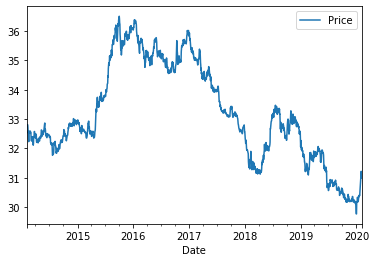

In [11]:
ds.plot()

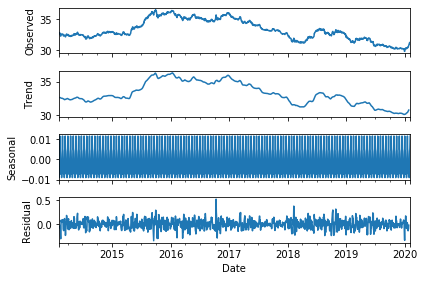

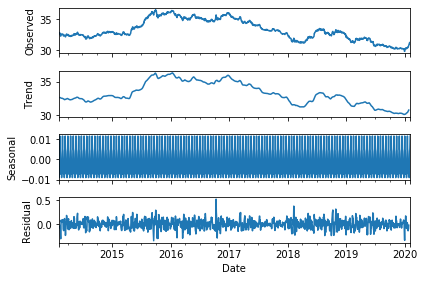

In [12]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomp=seasonal_decompose(ds['Price'], freq=12)  
decomp.plot()

In [13]:
from statsmodels.tsa.stattools import adfuller
adfuller(ds['Price'])

(-0.82085166373195,
 0.8129201892361418,
 3,
 1562,
 {'1%': -3.434543392468286,
  '5%': -2.863392129986099,
  '10%': -2.567756042468289},
 -2990.7132901993236)

In [14]:
def adf_chec(time_series):
    result=adfuller(time_series)
    print("Augmented Dickey fuller test")
    labels=['ADF Test Statistic', 'P-value', '#Lags', 'No of obs.']
    for value, label in zip(result, labels):
        print(label + ':' + str(value))
    if result[1]<=0.05:
        print('Strong evidence against null hypothesis, timeseries is stationery')
    else: 
        print('Weak evidence against null hypothesis, timeseries is non-stationery')

In [15]:
adf_chec(ds['Price'])

Augmented Dickey fuller test
ADF Test Statistic:-0.82085166373195
P-value:0.8129201892361418
#Lags:3
No of obs.:1562
Weak evidence against null hypothesis, timeseries is non-stationery


In [16]:
ds['Price First Diff']=ds['Price']-ds['Price'].shift(1)  

In [17]:
ds.head()

,Price,Price First Diff
Date,,
2014-02-04,32.750,NaN
2014-02-05,32.760,0.010
2014-02-06,32.790,0.030
2014-02-07,32.810,0.020
2014-02-10,32.805,-0.005


In [18]:
adf_chec(ds['Price First Diff'].dropna())

Augmented Dickey fuller test
ADF Test Statistic:-21.68382040278532
P-value:0.0
#Lags:2
No of obs.:1562
Strong evidence against null hypothesis, timeseries is stationery


In [19]:
#p=0;d=1;q=0

In [20]:
ds['Seasonal Difference']=ds['Price']-ds['Price'].shift(12)  

In [21]:
ds.head()

,Price,Price First Diff,Seasonal Difference
Date,,,
2014-02-04,32.750,NaN,NaN
2014-02-05,32.760,0.010,NaN
2014-02-06,32.790,0.030,NaN
2014-02-07,32.810,0.020,NaN
2014-02-10,32.805,-0.005,NaN


In [22]:
adf_chec(ds['Seasonal Difference'].dropna())

Augmented Dickey fuller test
ADF Test Statistic:-4.490471476472073
P-value:0.0002045842109703673
#Lags:24
No of obs.:1529
Strong evidence against null hypothesis, timeseries is stationery


In [23]:
#d=1, D=0

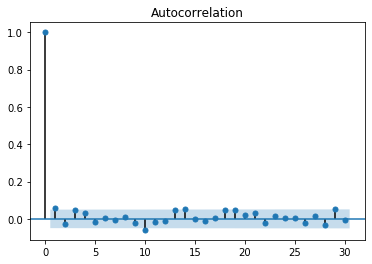

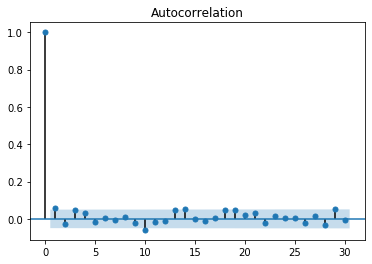

In [24]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(ds['Price First Diff'].dropna(), lags=30)

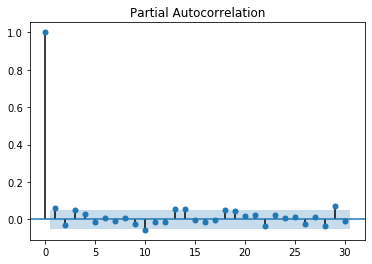

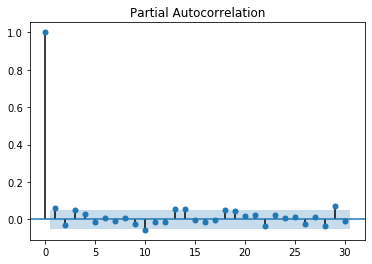

In [25]:
#q=1
plot_pacf(ds['Price First Diff'].dropna(), lags=30)
#p=1

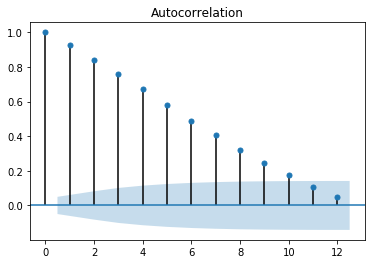

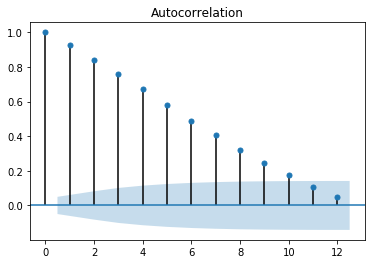

In [26]:
plot_acf(ds['Seasonal Difference'].dropna(), lags=12) #Q=6

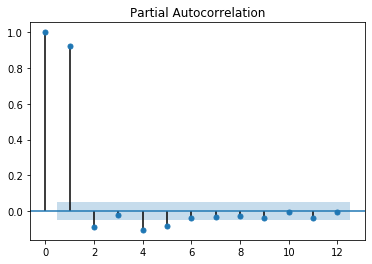

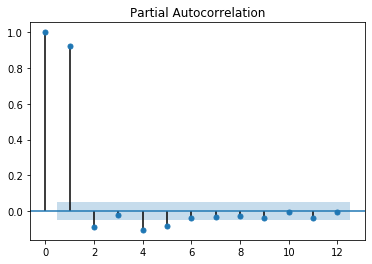

In [27]:
plot_pacf(ds['Seasonal Difference'].dropna(), lags=12) #P=1

In [28]:
#Finally,       AR  I  MA
#      TREND :  1   1  1

#SEASONALITY :  1  0   6


In [29]:
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm
model=sm.tsa.statespace.SARIMAX(ds['Price'],order=(1,1,1), seasonal_order=(1,1,1,12))
results=model.fit()


C:\Users\Adhvaidh\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  % freq, ValueWarning)
C:\Users\Adhvaidh\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:949: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Adhvaidh\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:961: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


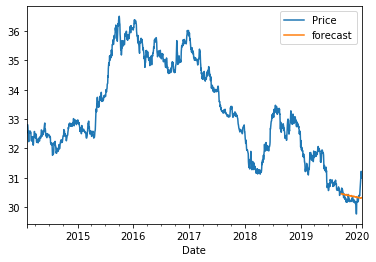

In [30]:
ds['forecast']=results.predict(start=1470, end=1565, dynamic=True)
ds[['Price','forecast']].plot()

In [31]:
from pandas.tseries.offsets import DateOffset
future_dates=[ds.index[-1]+ DateOffset(days=x) for x in range(0,365)]

In [32]:
future_dates_df_1=pd.DataFrame(index=future_dates[1:], columns=ds.columns)
future_df_1=pd.concat([ds,future_dates_df_1])

In [33]:
future_dates_df_1

,Price,Price First Diff,Seasonal Difference,forecast
2020-02-05,NaN,NaN,NaN,NaN
2020-02-06,NaN,NaN,NaN,NaN
2020-02-07,NaN,NaN,NaN,NaN
2020-02-08,NaN,NaN,NaN,NaN
2020-02-09,NaN,NaN,NaN,NaN
2020-02-10,NaN,NaN,NaN,NaN
2020-02-11,NaN,NaN,NaN,NaN
2020-02-12,NaN,NaN,NaN,NaN
2020-02-13,NaN,NaN,NaN,NaN
2020-02-14,NaN,NaN,NaN,NaN


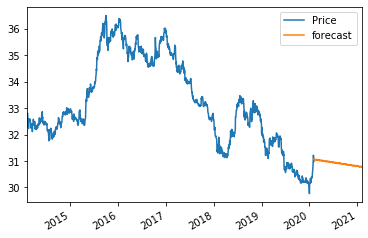

In [34]:
future_df_1['forecast']=results.predict(start=1565, end=1950, dynamic=True)
future_df_1[['Price','forecast']].plot()

In [35]:
future_df_1.tail(-1565)

,Price,Price First Diff,Seasonal Difference,forecast
2020-02-04,30.985,-0.1,0.585,31.077078
2020-02-05,NaN,NaN,NaN,31.073547
2020-02-06,NaN,NaN,NaN,31.069010
2020-02-07,NaN,NaN,NaN,31.065259
2020-02-08,NaN,NaN,NaN,NaN
2020-02-09,NaN,NaN,NaN,NaN
2020-02-10,NaN,NaN,NaN,31.057944
2020-02-11,NaN,NaN,NaN,31.053026
2020-02-12,NaN,NaN,NaN,31.056086
2020-02-13,NaN,NaN,NaN,31.053571


In [36]:
future_df_2=future_df_1.drop(['Price','Price First Diff','Seasonal Difference'],axis=1)

In [37]:
future_df_2.tail(-1885)

,forecast
2020-12-20,NaN
2020-12-21,30.818602
2020-12-22,30.816466
2020-12-23,30.811911
2020-12-24,30.806101
2020-12-25,30.801730
2020-12-26,NaN
2020-12-27,NaN
2020-12-28,30.806247
2020-12-29,30.804974


In [38]:
future_df_2=future_df_2.tail(-1565)

In [39]:
future_df_2.to_excel(r'C:\Users\Adhvaidh\Desktop\USD INR Prediction\USD THB Prediction.xlsx')